In [5]:
import yaml
import argparse
import itertools
from collections import defaultdict
from pathlib import Path
import multiprocessing
from multiprocessing import Pool, cpu_count
import concurrent.futures
from typing import Dict, List
from src.runner import Runner
import yaml
import argparse
import itertools
from collections import defaultdict
from pathlib import Path
import multiprocessing
from multiprocessing import Pool, cpu_count
import concurrent.futures
from typing import Dict, List
from src.runner import Runner
import os
from src.plotCurves import EvalCurves

class InputSettings(object):
    def __init__(self,
            datadir, datasets, algorithms) -> None:
        
        self.datadir = datadir
        self.datasets = datasets
        self.algorithms = algorithms


class OutputSettings(object):
    '''
    Structure for storing the names of directories that output should
    be written to
    '''

    def __init__(self, base_dir: Path) -> None:
        self.base_dir = base_dir

        
class Evaluation(object):
    '''
    The Evaluation object is created by parsing a user-provided configuration
    file. Its methods provide for further processing its inputs into
    a series of jobs to be run, as well as running these jobs.
    '''

    def __init__(self,
            input_settings: InputSettings,
            output_settings: OutputSettings) -> None:

        self.input_settings = input_settings
        self.output_settings = output_settings
        self.runners: Dict[int, Runner] = self.__create_runners()


    def __create_runners(self) -> Dict[int, List[Runner]]:
        '''
        Instantiate the set of runners based on parameters provided via the
        configuration file. Each runner is supplied an interactome, collection,
        the set of algorithms to be run, and graphspace credentials, in
        addition to the custom parameters each runner may or may not define.
        '''
        
        runners: Dict[int, Runner] = defaultdict(list)
        order = 0
        for dataset in self.input_settings.datasets:
            for runner in self.input_settings.algorithms:
                data = {}
                data['name'] = runner[0]
                data['params'] = runner[1]
                data['inputDir'] = Path.cwd().joinpath(self.input_settings.datadir.joinpath(dataset['name']))
                print(data['inputDir'])
                runners[order] = Runner(data)
                order += 1            
        return runners


    def execute_runners(self, parallel=False, num_threads=1):
        '''
        Run each of the algorithms
        '''

        base_output_dir = self.output_settings.base_dir

        batches =  self.runners.keys()

        for batch in batches:
            if parallel==True:
                executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
                futures = [executor.submit(runner.run, base_output_dir)
                    for runner in self.runners[batch]]
                
                # https://stackoverflow.com/questions/35711160/detect-failed-tasks-in-concurrent-futures
                # Re-raise exception if produced
                for future in concurrent.futures.as_completed(futures):
                    future.result()
                executor.shutdown(wait=True)
            else:
                for runner in self.runners[batch]:
                    runner.run(output_dir=base_output_dir)
                    
            
    def evaluate_runners(self):
        '''
        Plot PR and ROC curves for each dataset
        for all the algorithms
        '''
        for dataset in self.input_settings.datasets:              
            EvalCurves(dataset, self.input_settings)
                
                
class ConfigParser(object):
    '''
    Define static methods for parsing a config file that sets a large number
    of parameters for the pipeline
    '''
    @staticmethod
    def parse(config_file_handle) -> Evaluation:
        config_map = yaml.load(config_file_handle)
        return Evaluation(
            ConfigParser.__parse_input_settings(
                config_map['input_settings']),
            ConfigParser.__parse_output_settings(
                config_map['output_settings']))

    @staticmethod
    def __parse_input_settings(input_settings_map) -> InputSettings:
        input_dir = input_settings_map['input_dir']
        dataset_dir = input_settings_map['dataset_dir']
        datasets = input_settings_map['datasets']

        return InputSettings(
                Path(input_dir, dataset_dir),
                datasets,
                ConfigParser.__parse_algorithms(
                input_settings_map['algorithms']))


    @staticmethod
    def __parse_algorithms(algorithms_list):
        algorithms = []
        for algorithm in algorithms_list:
                combos = [dict(zip(algorithm['params'], val))
                    for val in itertools.product(
                        *(algorithm['params'][param]
                            for param in algorithm['params']))]
                for combo in combos:
                    algorithms.append([algorithm['name'],combo])
            

        return algorithms

    @staticmethod
    def __parse_output_settings(output_settings_map):
        output_dir = Path(output_settings_map['output_dir'])
        return OutputSettings(output_dir)

def get_parser() -> argparse.ArgumentParser:
    '''
    :return: an argparse ArgumentParser object for parsing command
        line parameters
    '''
    parser = argparse.ArgumentParser(
        description='Run pathway reconstruction pipeline.')

    parser.add_argument('--config', default='config.yaml',
        help='Configuration file')

    return parser

def parse_arguments():
    '''
    Initialize a parser and use it to parse the command line arguments
    :return: parsed dictionary of command line arguments
    '''
    parser = get_parser()
    opts = parser.parse_args()

    return opts

In [6]:
with open("config.yaml", 'r') as conf:
    evaluation = ConfigParser.parse(conf)
print(evaluation)
print('Evaluation started')

# Do something

print('Evaluation complete')

/home/adyprat/ModelEval/inputs/simulated/DS4
/home/adyprat/ModelEval/inputs/simulated/DS4
/home/adyprat/ModelEval/inputs/simulated/DS4
/home/adyprat/ModelEval/inputs/simulated/DS4
/home/adyprat/ModelEval/inputs/simulated/DS4
/home/adyprat/ModelEval/inputs/simulated/DS4
/home/adyprat/ModelEval/inputs/simulated/DS4
/home/adyprat/ModelEval/inputs/simulated/DS4
Evaluation started
Evaluation complete


In [7]:
evaluation.input_settings.datasets

[{'name': 'DS4',
  'ex_filename': 'ExpressionData.csv',
  'pt_filename': 'PseudoTime.csv',
  'trueEdges': 'randNetwork.tsv'}]

In [8]:
for alg in evaluation.input_settings.algorithms:
    print(alg)

['SCODE', {'should_run': True, 'nGenes': 10, 'z': 4, 'nCells': 210, 'nIter': 100, 'nRep': 5}]
['SINCERITIES', {'should_run': True}]
['PIDC', {'should_run': True}]
['GRNVBEM', {'should_run': True}]
['GENIE3', {'should_run': True}]
['GRNBOOST2', {'should_run': True}]
['LEAP', {'should_run': True}]
['JUMP3', {'should_run': True}]


In [9]:
Path.cwd().joinpath(evaluation.input_settings.datadir)

PosixPath('/home/adyprat/ModelEval/inputs/simulated')

In [10]:
evaluation.runners[1].generateInputs()

In [11]:
for idx in range(len(evaluation.runners)):
    evaluation.runners[idx].generateInputs()

Input folder for JUMP3 does not exist, creating input folder...


In [5]:
#os.system("jupyter nbconvert --to script bench.ipynb")

0

In [12]:
for idx in range(len(evaluation.runners)):
    evaluation.runners[idx].run()
    


docker run --rm -v ~/ModelEval:/SCODE/data/  scode:base /bin/sh -c "ruby run_R.rb data/inputs/simulated/DS4/SCODE/ExpressionData.csv data/inputs/simulated/DS4/SCODE/PseudoTime.csv  data/outputs/simulated/DS4/SCODE/ 10 4 210 100 5 "
docker run --rm -v ~/ModelEval:/SINCERITIES/data/ sincerities:base /bin/sh -c "Rscript MAIN.R data/inputs/simulated/DS4/SINCERITIES/ExpressionData.csv data/outputs/simulated/DS4/SINCERITIES/outFile.txt "
docker run --rm -v ~/ModelEval:/data pidc:base /bin/sh -c "julia runPIDC.jl data/inputs/simulated/DS4/PIDC/ExpressionData.csv data/outputs/simulated/DS4/PIDC/outFile.txt "
docker run --rm -v ~/ModelEval:/VBEM/data/ grnvbem:base /bin/sh -c "./GRNVBEM  data/inputs/simulated/DS4/GRNVBEM/ExpressionData.csv data/outputs/simulated/DS4/GRNVBEM/outFile.txt "
docker run --rm -v ~/ModelEval:/data/ --expose=41269 arboreto:base /bin/sh -c "python runArboreto.py --algo=GENIE3 --inFile=data/inputs/simulated/DS4/GENIE3/ExpressionData.csv --outFile=data/outputs/simulated/DS

In [3]:
for idx in range(len(evaluation.runners)):
    evaluation.runners[idx].parseOutput()

In [3]:
evaluation.runners[6].parseOutput()

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

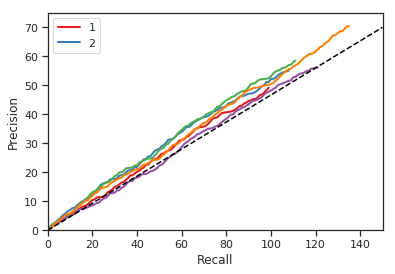

In [18]:
pDict = {}
rDict = {}
#plt.style.use('ggplot')
plt.clf()
sns.set(rc={"lines.linewidth": 2}, palette  = "Set1", style = "ticks")
keys = [1, 2, 3, 4 ,5]
for key in keys:
    pDict[key] = [0]
    rDict[key] = [0]
    for i in range(0,np.random.randint(100,150)):
        pDict[key].append(pDict[key][-1]+np.random.random())
        rDict[key].append(i)
    
for key in pDict.keys():
    sns.lineplot(rDict[key],pDict[key])

plt.plot([0, 150], [0,70], linewidth = 1.5, color = 'k', linestyle = '--')

plt.xlim(0,150)    
plt.ylim(0,75)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['1','2']) 
        


In [11]:
import pandas as pd

In [19]:
DF = pd.read_csv('inputs/simulated/dataset1/ExpressionData.csv', header= 0, index_col = 0)
newDF = DF.T.copy()
pDF = pd.read_csv('inputs/simulated/dataset1/PseudoTime.csv', header= 0, index_col = 0)
newDF['Time'] = pDF['Time']
DF.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c347,c348,c349,c350,c351,c352,c353,c354,c355,c356
SOX2,1.245513,1.219480,1.273929,1.290600,1.592997,1.419606,1.269637,1.078170,1.065146,1.317938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047353
ESRRB,1.279713,1.276735,1.167757,1.228051,1.388465,1.393951,1.229218,1.164620,1.180736,1.266996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UTF1,1.417324,1.546119,1.554748,1.225030,1.775559,1.606876,1.663052,1.519041,1.575766,1.678738,...,0.000000,0.119715,0.118964,0.225039,0.000000,0.000000,0.000000,0.093533,0.037996,0.838893
EPAS1,0.551417,0.557738,0.490467,0.350676,0.896887,0.276154,0.625784,0.338052,0.428949,0.334456,...,1.305164,1.220422,1.377212,1.146544,1.452294,1.439233,1.463899,1.544450,1.302433,1.333536
FOXQ1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.329386,0.924943,0.769071,1.138742,0.625939,1.030036,0.702981,0.954932,0.704600,1.116445


In [3]:
evaluation.runners

defaultdict(list,
            {0: <src.runner.Runner at 0x7fe1ac0ac5f8>,
             1: <src.runner.Runner at 0x7fe1ac0ac898>,
             2: <src.runner.Runner at 0x7fe1ac0ac2e8>,
             3: <src.runner.Runner at 0x7fe1ac0ac8d0>,
             4: <src.runner.Runner at 0x7fe1ac0ac748>,
             5: <src.runner.Runner at 0x7fe1ac0ac860>})

SCODE
SINCERITIES
PIDC
GRNVBEM
GENIE3
GRNBOOST2
LEAP
JUMP3


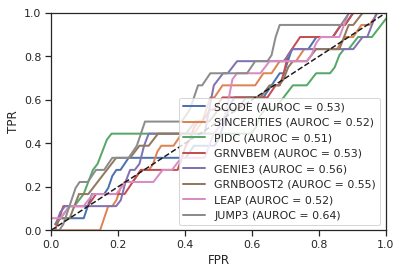

In [7]:
evaluation.evaluate_runners()

In [8]:
dataDict = evaluation.input_settings.datasets[0]

In [9]:
inputSettings = evaluation.input_settings
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

outputs/simulated/dataset1/SCNS/rankedEdges.csv  does not exist. Skipping...
SCODE


/home/adyprat/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


SINCERITIES
PIDC
GRNVBEM
GENIE3
GRNBOOST2


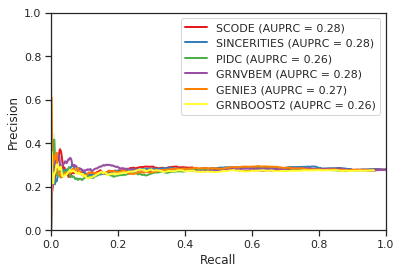

In [10]:
# Read file for trueEdges
trueEdgesFile = pd.read_csv(str(inputSettings.datadir)+'/'+ dataDict['name'] +
                            '/' +'reference_TFTF_network.txt',
                            sep = '\t', header = 0, index_col = None)



# Initialize data dictionaries
precisionDict = {}
recallDict = {}
FPRDict = {}
AUPRC = {}

outDir = "outputs/"+str(inputSettings.datadir).split("inputs/")[1]+ '/' +dataDict['name']
for algo in inputSettings.algorithms:
    tp = 0
    fp = 0
    total = 0 # total predictions made
    totalTrue = trueEdgesFile.shape[0] # Condition Positives
    
    # check if the output rankedEdges file exists
    if Path(outDir + '/' +algo[0]+'/rankedEdges.csv').exists():
        precisionDict[algo[0]] = [] # Initialize Precsion
        recallDict[algo[0]] = [] # Initialize Recall
        FPRDict[algo[0]] = [] # Initialize FPR
        predEdgesFile = pd.read_csv(outDir + '/' +algo[0]+'/rankedEdges.csv', \
                                    sep = '\t', header =  0, index_col = None)
        pOld = 0
        rOld = 0
        AUPRC[algo[0]] = 0 # Initialize AUPRC
        for idx, row in predEdgesFile.iterrows():
            if trueEdgesFile.loc[(trueEdgesFile['Gene1'] == row['Gene1']) & \
                                 (trueEdgesFile['Gene2'] == row['Gene2'])].shape[0] > 0:
                tp += 1
            else:
                fp += 1
            total += 1

            pNew = float(tp)/float(total)
            rNew = float(tp)/float(totalTrue)

            precisionDict[algo[0]].append(pNew)
            recallDict[algo[0]].append(rNew)

            AUPRC[algo[0]] += ((rNew - rOld)*(pOld + pNew)/2) # compute AUPRC

            pOld = pNew
            rOld = rNew
            FPRDict[algo[0]].append(float(fp)) # List of FP values

        FPRDict[algo[0]] = [val/float(total - totalTrue) for val in FPRDict[algo[0]]] # update FPR

    else:
        print(outDir + '/' +algo[0]+'/rankedEdges.csv', \
              ' does not exist. Skipping...')

## Make PR curves
legendList = []
for key in precisionDict.keys():
    print(key)
    sns.lineplot(recallDict[key],precisionDict[key])
    legendList.append(str(key) + ' (AUPRC = ' + str("%.2f" % (AUPRC[key]))+')')

plt.xlim(0,1)    
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(legendList) 

In [19]:
fp

1593

In [8]:
import pandas as pd
DF = pd.read_csv('inputs/simulated/dataset1/ExpressionData.csv', header= 0, index_col = 0)
pDF = pd.read_csv('inputs/simulated/dataset1/PseudoTime.csv', header= 0, index_col = 0)
DF[pDF.sort_values(['PseudoTime']).index].head()

,c33,c53,c3,c47,c67,c30,c64,c49,c20,c18,...,c318,c319,c315,c306,c328,c301,c343,c346,c307,c337
SOX2,1.207739,1.131859,1.273929,1.228341,1.207457,1.347742,1.294244,1.270301,0.673372,1.167187,...,0.000000,0.000000,0.022750,0.012577,0.000000,0.000000,0.000000,0.000000,0.000000,0.041987
ESRRB,1.309502,1.382944,1.167757,1.278879,1.362136,1.461041,1.200626,1.466985,1.365031,1.262795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UTF1,0.887411,1.067413,1.554748,1.571531,1.322056,1.638627,1.428033,1.239905,1.686085,1.522945,...,0.000000,0.064483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.338938
EPAS1,0.078518,0.374048,0.490467,0.673594,0.558087,0.528945,0.477813,0.286092,0.240735,0.618417,...,1.412113,1.457596,1.317854,1.340016,1.362222,1.698906,1.596973,1.522050,1.471538,1.709350
FOXQ1,0.000000,0.000000,0.000000,0.000000,0.047418,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.925106,0.939707,1.277891,0.870892,1.144854,0.966274,0.495990,0.899653,1.077230,0.913330


In [26]:
NetDF = pd.read_csv('inputs/simulated/dataset1/reference_TFTF_network.txt', sep = '\t', header= 0, index_col = None)
DF.loc[pd.unique(NetDF[['Gene1','Gene2']].values.ravel('K'))].to_csv('inputs/simulated/dataset1/ExpressionData.csv',\
                                                                     sep = ',', header  = True, index = True)

In [27]:
DF = pd.read_csv('inputs/simulated/dataset1/ExpressionData.csv', header= 0, index_col = 0)
DF.T.to_csv('/home/adyprat/ModelEval/Algorithms/GENIE3/temp.tsv', sep = '\t')